In [1]:
from google.colab import files
uploadFolder = files.upload()

Saving Satellite Image Classification.zip to Satellite Image Classification.zip


In [2]:
import zipfile
import os

datasetZip = "Satellite Image Classification.zip"
extractFolder = "/content/Satellite Image Classification"

with zipfile.ZipFile(datasetZip, 'r') as zip_ref:
  zip_ref.extractall(extractFolder)

print("Dataset Extracted Succesfully")


Dataset Extracted Succesfully


In [3]:
satelliteDatasetPath = "/content/Satellite Image Classification/data"

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from collections import Counter
import os

import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2, InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [5]:
satelliteImgHeight = 75
satelliteImgWidth = 75

In [6]:
rawTrainData = keras.utils.image_dataset_from_directory(satelliteDatasetPath,
                                                                 subset = "training",
                                                                 seed = 42,
                                                                 image_size = (satelliteImgHeight, satelliteImgWidth),
                                                                 label_mode = "categorical",
                                                                 validation_split = 0.20,
                                                                 batch_size = 64
                                                                )
rawValidationData = keras.utils.image_dataset_from_directory(satelliteDatasetPath,
                                                                   subset = "validation",
                                                                   seed = 42,
                                                                   image_size = (satelliteImgHeight, satelliteImgWidth),
                                                                   label_mode = "categorical",
                                                                   validation_split = 0.20,
                                                                   batch_size = 64
                                                                  )

AUTOTUNE = tf.data.AUTOTUNE

satelliteTrainingData = rawTrainData.cache().shuffle(1000).prefetch(AUTOTUNE)

satelliteValidationData = keras.utils.image_dataset_from_directory(satelliteDatasetPath,
                                                                   subset = "validation",
                                                                   seed = 42,
                                                                   image_size = (satelliteImgHeight, satelliteImgWidth),
                                                                   label_mode = "categorical",
                                                                   validation_split = 0.20,
                                                                   batch_size = 64
                                                                  ).cache().prefetch(AUTOTUNE)

Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


In [7]:
dataAugmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.2)
])

satelliteTrainAugmented = satelliteTrainingData.map(lambda i, j: (dataAugmentation(i), j))
# satelliteTrainAugmented

In [8]:
satelliteNormalizationLayer = tf.keras.layers.Rescaling(1./255)

satelliteTrainNorm = satelliteTrainAugmented.map(lambda i, j: (satelliteNormalizationLayer(i), j))
satelliteValidationNorm = satelliteValidationData.map(lambda i, j: (satelliteNormalizationLayer(i), j))

In [9]:
classNames = rawTrainData.class_names
classNames

['cloudy', 'desert', 'green_area', 'water']

In [10]:
labels = []
for _, label in satelliteTrainNorm:
    # Convert one-hot to class index
    labels.extend(np.argmax(label.numpy(), axis = 1))

# Count Occurrences of each class
labelCounts = Counter(labels)
print(labelCounts)

# Print class-wise count
for ind, count in labelCounts.items():
    print(f"{classNames[ind]}: {count}")

Counter({0: 1233, 3: 1183, 2: 1182, 1: 907})
green_area: 1182
cloudy: 1233
water: 1183
desert: 907


In [11]:
classWeights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(labels),
    y = labels
)

classWeightDict = {i : classWeights[i] for i in range(len(classWeights))}
print(f"Computed Class Weights: {classWeightDict}")

Computed Class Weights: {0: 0.9134225466342255, 1: 1.2417309812568909, 2: 0.952834179357022, 3: 0.952028740490279}


In [12]:
autotune = tf.data.AUTOTUNE

satelliteTrainPrefetch = satelliteTrainNorm.prefetch(buffer_size = autotune).shuffle(buffer_size = 64)
satelliteValidationPrefetch = satelliteValidationNorm.prefetch(buffer_size = autotune)

In [24]:
checkpointPath = "/content/InceptionResNetV2_BestModel.keras"

In [25]:
# Define Checkpoint Callback (Saves the Best Model)
checkpointCallback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpointPath,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True,
    save_weights_only = False,
    verbose = 1
)

# Define Early Stopping
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True,
    verbose = 1
)

# Define the Learning Rate Scheduler
lrScheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.5,
    patience = 3,
    min_lr = 1e-6,
    verbose = 1
)

In [26]:
baseModel = InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape = (75, 75, 3))

In [27]:
for layer in baseModel.layers:
  layer.trainable = False

x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = "relu")(x)

num_classes = len(rawTrainData.class_names)
predictions = Dense(num_classes, activation = "softmax")(x)

cnnModel = Model(inputs = baseModel.input, outputs = predictions)

In [28]:
cnnModel.compile(optimizer = Adam(learning_rate = 0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [48]:
modelHistory = cnnModel.fit(
    satelliteTrainPrefetch,
    validation_data = satelliteValidationPrefetch,
    epochs = 30,
    class_weight = classWeightDict,
    callbacks = [checkpointCallback, earlyStopping, lrScheduler]
)


Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7258 - loss: 0.7111
Epoch 1: val_loss did not improve from 0.57750
71/71 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.7257 - loss: 0.7113 - val_accuracy: 0.7460 - val_loss: 0.6107 - learning_rate: 5.0000e-04
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7198 - loss: 0.7883
Epoch 2: val_loss did not improve from 0.57750
71/71 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.7199 - loss: 0.7876 - val_accuracy: 0.7433 - val_loss: 0.6886 - learning_rate: 5.0000e-04
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7192 - loss: 0.7487
Epoch 3: val_loss did not improve from 0.57750
71/71 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.7193 - loss: 0.7485 - val_accuracy: 0.7682 - val_loss: 0.5950 - learning_rate: 5.0000e-04
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7207 - loss: 0.7185
Epoch 4: val_loss did not improve from 0.57750
71/71 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accura

In [67]:
# Load the Best Model After Training
if os.path.exists(checkpointPath):
    print("Loading Best Model...")
    cnnModel = tf.keras.models.load_model(checkpointPath)

Loading Best Model...


In [68]:
cnnModel.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 75, 75, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_406 (Conv2D)       │ (None, 37, 37, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_406   │ (None, 37, 37, 32)     │             96 │ conv2d_406[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_406            │ (None, 37, 37, 32)     │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_407 (Conv2D)       │ (None, 35, 35, 32)     │          9,216 │ activation_406[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_407   │ (None, 35, 35, 32)     │             96 │ conv2d_407[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_407            │ (None, 35, 35, 32)     │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_408 (Conv2D)       │ (None, 35, 35, 64)     │         18,432 │ activation_407[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_408   │ (None, 35, 35, 64)     │            192 │ conv2d_408[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_408            │ (None, 35, 35, 64)     │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 17, 17, 64)     │              0 │ activation_408[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_409 (Conv2D)       │ (None, 17, 17, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_409   │ (None, 17, 17, 80)     │            240 │ conv2d_409[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_409            │ (None, 17, 17, 80)     │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_410 (Conv2D)  

 Total params: 59,070,702 (225.34 MB)

 Trainable params: 1,577,988 (6.02 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

 Optimizer params: 3,155,978 (12.04 MB)

In [66]:
validationLoss, validationAccuracy = cnnModel.evaluate(satelliteValidationPrefetch)
print(f"Validation Loss: {validationLoss:.2%}")
print(f"Validation Accuracy: {validationAccuracy:.2%}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7595 - loss: 0.5367
Validation Loss: 53.01%
Validation Accuracy: 76.38%


In [ ]:
trueLabels = []
predictedLabels = []

for images, labels in satelliteValidationPrefetch:
    pred = cnnModel.predict(images)
    predictedLabels.extend(np.argmax(pred, axis = 1))
    trueLabels.extend(np.argmax(labels.numpy(), axis = 1))

confusionMatrix = confusion_matrix(trueLabels, predictedLabels)
print(confusionMatrix)

fig = px.imshow(confusionMatrix,
                labels = dict(x = "Predicted", y = "Actual", color = "Count"),
                x = rawTrainData.class_names,
                y = rawTrainData.class_names,
                text_auto = True,
                title = "Confusion Matrix"
               )
fig.update_layout(width = 500, height = 400)

In [ ]:
# Accuracy
plt.plot(modelHistory.history['accuracy'], label = "Train Accuracy")
plt.plot(modelHistory.history['val_accuracy'], label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()


# Loss
plt.plot(modelHistory.history["loss"], label = "Train Loss")
plt.plot(modelHistory.history['val_loss'], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
from PIL import Image

In [61]:
img_path = "/content/Satellite Image Classification/data/cloudy/train_1060.jpg"
# img_path = "/content/Satellite Image Classification/data/desert/desert(37).jpg"
# img_path = "/content/Satellite Image Classification/data/green_area/Forest_89.jpg"
# img_path = "/content/Satellite Image Classification/data/water/SeaLake_1011.jpg"

In [ ]:
img = Image.open(img_path)

print(img.mode)

if img.mode == "CMYK":
    img = img.convert("RGB")

print(img.mode)

img = img.resize((128, 128))

img_array = np.array(img) / 255.0
print(img_array.shape)

img_array = np.expand_dims(img_array, axis = 0)
print(img_array.shape)

In [62]:
prediction = cnnModel.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


In [63]:
predictedClass = np.argmax(prediction)
predictedClass

3

In [64]:
classLabels = rawTrainData.class_names
classLabels

['cloudy', 'desert', 'green_area', 'water']

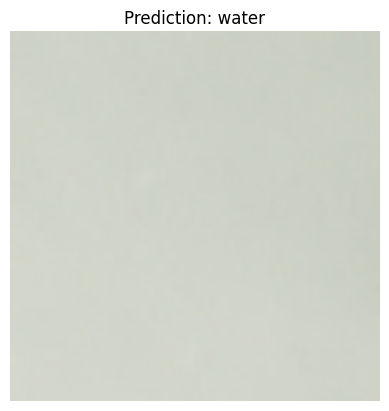

In [65]:
plt.imshow(img)
plt.title(f"Prediction: {classLabels[predictedClass]}")
plt.axis("off")
plt.show()